In [18]:
!pip install rdkit

# %% [markdown]
# # Molecule Generation Using GAN in PyTorch
#
# This notebook demonstrates an end-to-end workflow for generating novel molecules using a Generative Adversarial Network (GAN) implemented in PyTorch.
#
# **Workflow Overview:**
#
# 1. **Data Download & Preprocessing**
#    - Download an online SMILES dataset.
#    - Load and filter valid SMILES using RDKit.
#    - Create a vocabulary for tokenizing SMILES.
#    - Visualize the length distribution of SMILES strings.
#
# 2. **Dataset Creation**
#    - Define a custom PyTorch Dataset that tokenizes and pads the SMILES.
#    - Load the dataset using DataLoader.
#
# 3. **GAN Model Architecture**
#    - Define the Generator: maps latent vectors to SMILES sequences using an LSTM and Gumbel-Softmax.
#    - Define the Discriminator: classifies one-hot encoded SMILES using an embedding layer and bidirectional LSTM.
#
# 4. **Training the GAN**
#    - Train using an adversarial training loop.
#    - Print and plot losses over epochs.
#
# 5. **Molecule Generation and Evaluation**
#    - Generate new molecules using the trained Generator.
#    - Convert the outputs back to SMILES strings.
#    - Validate generated molecules using RDKit.
#    - Plot a grid of valid molecules.
#
# Let's get started!

In [19]:
# %%
import os
import json
import random
from pathlib import Path
from datetime import datetime
from typing import List, Dict, Any

import requests                     # For downloading datasets
import numpy as np                  # For numerical operations
import torch                        # Main PyTorch package
import torch.nn as nn               # For neural network modules
import torch.nn.functional as F     # For activation functions and utilities
import matplotlib.pyplot as plt     # For plotting graphs and images
from tqdm import tqdm               # For progress bars

# RDKit for molecule processing and visualization
from rdkit import Chem
from rdkit.Chem import Draw

# Determine device for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [20]:
# %% [markdown]
# ## 1. Data Download & Preprocessing
#
# In this section, we:
#
# - Download a sample SMILES dataset from an online repository.
# - Load SMILES strings from the file.
# - Filter out invalid SMILES using RDKit.
# - Build a character-level vocabulary for tokenizing the SMILES.
# - Plot the distribution of SMILES string lengths.
#
# **Note:** The dataset used here is a sample file from MolGAN’s repository.


In [21]:
# %%
def download_dataset(url: str, save_path: str) -> None:
    """
    Downloads the dataset from the specified URL if not already present locally.
    """
    if os.path.exists(save_path):
        print(f"Dataset already exists at {save_path}. Skipping download.")
        return

    print(f"Downloading dataset from {url} ...")
    response = requests.get(url, stream=True)
    total_length = response.headers.get('content-length')

    if total_length is None:
        with open(save_path, 'wb') as f:
            f.write(response.content)
    else:
        total_length = int(total_length)
        with open(save_path, 'wb') as f:
            for data in tqdm(response.iter_content(chunk_size=4096), total=total_length//4096, desc="Downloading"):
                f.write(data)
    print(f"Dataset downloaded and saved to {save_path}.")

def load_smiles_dataset(file_path: str) -> List[str]:
    """
    Loads SMILES strings from a text file (one SMILES per line).
    """
    smiles_list = []
    with open(file_path, 'r') as f:
        for line in f:
            line = line.strip()
            if line:
                smiles_list.append(line)
    print(f"Loaded {len(smiles_list)} SMILES strings from {file_path}.")
    return smiles_list

def filter_valid_smiles(smiles_list: List[str]) -> List[str]:
    """
    Filters out invalid SMILES strings using RDKit.
    """
    valid_smiles = []
    invalid_count = 0
    for smi in smiles_list:
        mol = Chem.MolFromSmiles(smi)
        if mol is not None:
            valid_smiles.append(smi)
        else:
            invalid_count += 1
    print(f"Filtered out {invalid_count} invalid SMILES. {len(valid_smiles)} valid SMILES remain.")
    return valid_smiles

def create_vocabulary(smiles_list: List[str]) -> Dict[str, int]:
    """
    Creates a character-to-index mapping from the SMILES strings.
    """
    vocab = {}
    for smi in smiles_list:
        for char in smi:
            if char not in vocab:
                vocab[char] = len(vocab)
    # Add special padding token.
    if "<PAD>" not in vocab:
        vocab["<PAD>"] = len(vocab)
    print(f"Created vocabulary with {len(vocab)} tokens.")
    return vocab

def tokenize_smiles(smiles: str, vocab: Dict[str, int]) -> List[int]:
    """
    Tokenizes a SMILES string using the provided vocabulary.
    """
    return [vocab[char] for char in smiles]

def pad_sequence(seq: List[int], max_length: int, pad_value: int) -> List[int]:
    """
    Pads or truncates a sequence to the maximum length.
    """
    padded_seq = seq[:max_length]
    padded_seq += [pad_value] * (max_length - len(padded_seq))
    return padded_seq


In [22]:
# %%
# Define the dataset URL and local filename.
#dataset_url = "https://raw.githubusercontent.com/tsudalab/MolGAN/master/data/zinc_sample.txt"
dataset_file = "zinc_sample.txt"

# Download the dataset if needed.
#download_dataset(dataset_url, dataset_file)

# Load SMILES strings from file.
smiles_list = load_smiles_dataset(dataset_file)

# Filter out invalid SMILES.
smiles_list = filter_valid_smiles(smiles_list)

# Build the vocabulary for tokenizing SMILES.
vocab = create_vocabulary(smiles_list)
print("Vocabulary:", vocab)

# Create the inverse mapping (for decoding tokens later).
idx_to_char = {idx: char for char, idx in vocab.items()}

# Determine the maximum sequence length in the dataset.
max_length = max(len(smi) for smi in smiles_list)
print("Maximum SMILES length:", max_length)


Loaded 482 SMILES strings from zinc_sample.txt.
Filtered out 0 invalid SMILES. 482 valid SMILES remain.
Created vocabulary with 10 tokens.
Vocabulary: {'C': 0, '1': 1, '=': 2, '(': 3, 'O': 4, ')': 5, '2': 6, '3': 7, '#': 8, '<PAD>': 9}
Maximum SMILES length: 62


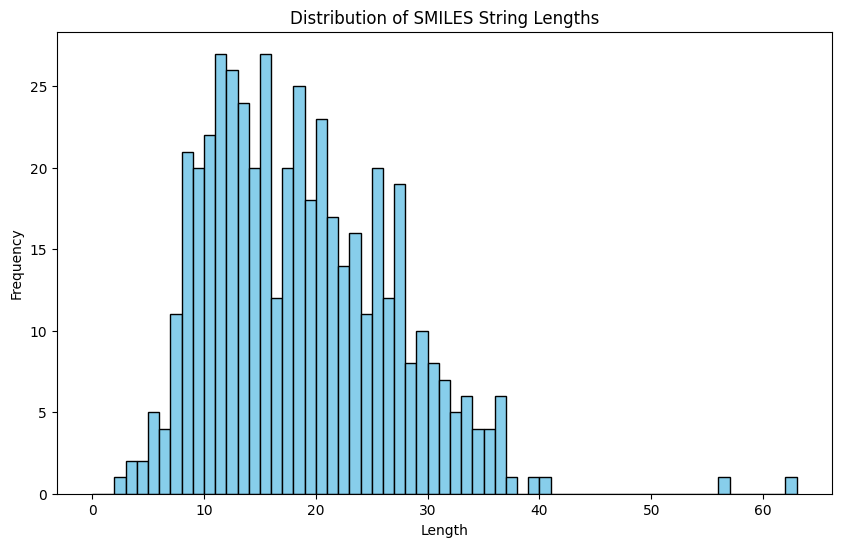

In [23]:
# %%
# Visualize the distribution of SMILES string lengths.
smiles_lengths = [len(smi) for smi in smiles_list]
plt.figure(figsize=(10, 6))
plt.hist(smiles_lengths, bins=range(0, max(smiles_lengths) + 2, 1), color='skyblue', edgecolor='black')
plt.title("Distribution of SMILES String Lengths")
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.show()

# %% [markdown]
# ## 2. Create a Custom PyTorch Dataset
#
# We now create a custom PyTorch Dataset that:
# - Tokenizes the SMILES strings.
# - Pads them to a fixed maximum length.
# - Converts them to tensors for model training.
#
# We then load the dataset using a DataLoader for batch processing.


In [24]:
# %%
from torch.utils.data import Dataset, DataLoader

class SmilesDataset(Dataset):
    def __init__(self, smiles_list: List[str], vocab: Dict[str, int], max_length: int):
        self.vocab = vocab
        self.max_length = max_length
        self.pad_value = vocab["<PAD>"]
        self.smiles_list = smiles_list
        # Tokenize and pad all SMILES strings.
        self.tokenized_data = [pad_sequence(tokenize_smiles(smi, vocab), max_length, self.pad_value)
                               for smi in smiles_list]

    def __len__(self):
        return len(self.tokenized_data)

    def __getitem__(self, idx):
        sample = self.tokenized_data[idx]
        return torch.tensor(sample, dtype=torch.long)


In [25]:
# %%
# Create the dataset and DataLoader.
batch_size = 64
dataset = SmilesDataset(smiles_list, vocab, max_length)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
print("DataLoader created with batch size:", batch_size)

# %% [markdown]
# ## 3. GAN Architecture: Generator and Discriminator
#
# We now define our GAN models:
#
# - **Generator:**
#   Takes a latent noise vector and maps it through a fully connected layer and an LSTM to produce a sequence of logits over the vocabulary. We then apply the Gumbel-Softmax trick to obtain a one-hot style output that represents a SMILES string.
#
# - **Discriminator:**
#   Converts one-hot encoded SMILES sequences into dense embeddings and uses a bidirectional LSTM to extract sequence features. The final linear layer outputs a probability that the input sequence is real.
#


DataLoader created with batch size: 64


In [26]:
# %%
class Generator(nn.Module):
    def __init__(self, latent_dim: int, hidden_dim: int, seq_length: int, vocab_size: int, temperature: float = 0.8):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        self.seq_length = seq_length
        self.vocab_size = vocab_size
        self.temperature = temperature

        # Project the latent vector to a sequence of hidden states.
        self.fc = nn.Linear(latent_dim, hidden_dim * seq_length)
        # LSTM for sequential modeling.
        self.lstm = nn.LSTM(input_size=hidden_dim, hidden_size=hidden_dim, num_layers=2, batch_first=True)
        # Final projection to vocabulary logits.
        self.fc_out = nn.Linear(hidden_dim, vocab_size)

    def forward(self, z: torch.Tensor) -> torch.Tensor:
        batch_size = z.size(0)
        x = self.fc(z)
        x = x.view(batch_size, self.seq_length, self.hidden_dim)
        lstm_out, _ = self.lstm(x)
        logits = self.fc_out(lstm_out)
        # Apply Gumbel-Softmax to sample differentiably from the logits.
        gumbel_output = F.gumbel_softmax(logits, tau=self.temperature, hard=True, dim=-1)
        return gumbel_output

class Discriminator(nn.Module):
    def __init__(self, vocab_size: int, embed_dim: int, hidden_dim: int, seq_length: int):
        super(Discriminator, self).__init__()
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.hidden_dim = hidden_dim
        self.seq_length = seq_length

        # Linear layer to convert one-hot vectors to embeddings.
        self.embedding = nn.Linear(vocab_size, embed_dim)
        # Bidirectional LSTM for extracting sequential features.
        self.lstm = nn.LSTM(input_size=embed_dim, hidden_size=hidden_dim, num_layers=2,
                            batch_first=True, bidirectional=True)
        # Final fully connected layer for classification.
        self.fc = nn.Linear(hidden_dim * 2, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x_embed = self.embedding(x)
        lstm_out, _ = self.lstm(x_embed)
        lstm_last = torch.mean(lstm_out, dim=1)  # Use average pooling over time steps.
        logits = self.fc(lstm_last)
        prob = torch.sigmoid(logits)
        return prob


In [27]:
# %%
# Set hyperparameters for our models.
latent_dim = 100
gen_hidden_dim = 256
disc_hidden_dim = 256
embed_dim = 128
temperature = 0.8
vocab_size = len(vocab)
seq_length = max_length

# Initialize the Generator and Discriminator.
generator = Generator(latent_dim, gen_hidden_dim, seq_length, vocab_size, temperature).to(device)
# For ease of use in training, add vocab_size as an attribute.
generator.vocab_size = vocab_size
discriminator = Discriminator(vocab_size, embed_dim, disc_hidden_dim, seq_length).to(device)

print("Generator and Discriminator have been initialized.")

# %% [markdown]
# ## 4. Training the GAN
#
# In this section, we train the GAN using an adversarial training loop.
#
# **Training Details:**
#
# - **Discriminator Training:**
#   The discriminator is trained on both real SMILES (converted to one-hot encoding) and fake SMILES generated by the Generator. Binary cross entropy loss is used.
#
# - **Generator Training:**
#   The generator is trained to fool the discriminator, so we train it with the goal of getting the discriminator to predict "real" for its generated samples.
#
# The losses for both models are printed and stored for later visualization.


Generator and Discriminator have been initialized.


In [28]:
# %%
def train_gan(generator: nn.Module,
              discriminator: nn.Module,
              data_loader: DataLoader,
              latent_dim: int,
              num_epochs: int,
              device: torch.device,
              lr: float = 0.0002) -> Dict[str, List[float]]:
    """
    Trains the GAN using adversarial training.
    """
    # Loss function and optimizers.
    criterion = nn.BCELoss()
    optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

    loss_history = {"G": [], "D": []}

    generator.train()
    discriminator.train()

    for epoch in range(num_epochs):
        epoch_loss_G = 0.0
        epoch_loss_D = 0.0

        for real_sequences in tqdm(data_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            batch_size = real_sequences.size(0)
            real_sequences = real_sequences.to(device)

            # Convert real sequences (indices) to one-hot encoding.
            real_onehot = F.one_hot(real_sequences, num_classes=vocab_size).float().to(device)

            # Create labels.
            real_labels = torch.ones(batch_size, 1, device=device)
            fake_labels = torch.zeros(batch_size, 1, device=device)

            # ---------------------------
            # Train the Discriminator
            # ---------------------------
            optimizer_D.zero_grad()
            output_real = discriminator(real_onehot)
            loss_real = criterion(output_real, real_labels)

            # Generate fake samples.
            z = torch.randn(batch_size, latent_dim, device=device)
            fake_onehot = generator(z)
            output_fake = discriminator(fake_onehot.detach())
            loss_fake = criterion(output_fake, fake_labels)

            loss_D = loss_real + loss_fake
            loss_D.backward()
            optimizer_D.step()

            # ---------------------------
            # Train the Generator
            # ---------------------------
            optimizer_G.zero_grad()
            output_fake_for_G = discriminator(fake_onehot)
            loss_G = criterion(output_fake_for_G, real_labels)
            loss_G.backward()
            optimizer_G.step()

            epoch_loss_D += loss_D.item()
            epoch_loss_G += loss_G.item()

        avg_loss_D = epoch_loss_D / len(data_loader)
        avg_loss_G = epoch_loss_G / len(data_loader)
        loss_history["D"].append(avg_loss_D)
        loss_history["G"].append(avg_loss_G)
        print(f"Epoch {epoch+1}/{num_epochs} - Loss_D: {avg_loss_D:.4f}, Loss_G: {avg_loss_G:.4f}")

    return loss_history


In [35]:
# %%
# Set the number of epochs and start training.
num_epochs = 50
print("Starting GAN training...")
loss_history = train_gan(generator, discriminator, data_loader, latent_dim, num_epochs, device, lr=0.0002)
print("Training complete.")


Starting GAN training...


Epoch 1/50: 100%|██████████| 7/7 [00:39<00:00,  5.61s/it]


Epoch 1/50 - Loss_D: 1.0325, Loss_G: 1.5342


Epoch 2/50: 100%|██████████| 7/7 [00:38<00:00,  5.54s/it]


Epoch 2/50 - Loss_D: 0.6443, Loss_G: 1.5820


Epoch 3/50: 100%|██████████| 7/7 [00:38<00:00,  5.46s/it]


Epoch 3/50 - Loss_D: 0.6309, Loss_G: 1.7064


Epoch 4/50: 100%|██████████| 7/7 [00:38<00:00,  5.55s/it]


Epoch 4/50 - Loss_D: 0.4745, Loss_G: 1.9398


Epoch 5/50: 100%|██████████| 7/7 [00:38<00:00,  5.48s/it]


Epoch 5/50 - Loss_D: 0.4515, Loss_G: 2.2541


Epoch 6/50: 100%|██████████| 7/7 [00:38<00:00,  5.43s/it]


Epoch 6/50 - Loss_D: 0.5160, Loss_G: 2.2076


Epoch 7/50: 100%|██████████| 7/7 [00:38<00:00,  5.44s/it]


Epoch 7/50 - Loss_D: 0.7102, Loss_G: 2.0073


Epoch 8/50: 100%|██████████| 7/7 [00:38<00:00,  5.46s/it]


Epoch 8/50 - Loss_D: 0.7299, Loss_G: 1.9907


Epoch 9/50: 100%|██████████| 7/7 [00:38<00:00,  5.48s/it]


Epoch 9/50 - Loss_D: 0.3384, Loss_G: 2.1655


Epoch 10/50: 100%|██████████| 7/7 [00:40<00:00,  5.75s/it]


Epoch 10/50 - Loss_D: 0.1619, Loss_G: 2.7661


Epoch 11/50: 100%|██████████| 7/7 [00:40<00:00,  5.78s/it]


Epoch 11/50 - Loss_D: 0.0813, Loss_G: 3.2380


Epoch 12/50: 100%|██████████| 7/7 [00:40<00:00,  5.75s/it]


Epoch 12/50 - Loss_D: 0.0411, Loss_G: 3.9228


Epoch 13/50: 100%|██████████| 7/7 [00:39<00:00,  5.58s/it]


Epoch 13/50 - Loss_D: 0.0267, Loss_G: 4.5419


Epoch 14/50: 100%|██████████| 7/7 [00:38<00:00,  5.46s/it]


Epoch 14/50 - Loss_D: 0.0218, Loss_G: 4.8218


Epoch 15/50: 100%|██████████| 7/7 [00:38<00:00,  5.44s/it]


Epoch 15/50 - Loss_D: 0.0202, Loss_G: 4.9788


Epoch 16/50: 100%|██████████| 7/7 [00:38<00:00,  5.49s/it]


Epoch 16/50 - Loss_D: 0.0195, Loss_G: 5.1006


Epoch 17/50: 100%|██████████| 7/7 [00:38<00:00,  5.44s/it]


Epoch 17/50 - Loss_D: 0.0188, Loss_G: 5.1823


Epoch 18/50: 100%|██████████| 7/7 [00:38<00:00,  5.44s/it]


Epoch 18/50 - Loss_D: 0.0178, Loss_G: 5.2963


Epoch 19/50: 100%|██████████| 7/7 [00:39<00:00,  5.58s/it]


Epoch 19/50 - Loss_D: 0.0181, Loss_G: 5.3874


Epoch 20/50: 100%|██████████| 7/7 [00:39<00:00,  5.63s/it]


Epoch 20/50 - Loss_D: 0.0178, Loss_G: 5.4995


Epoch 21/50: 100%|██████████| 7/7 [00:39<00:00,  5.65s/it]


Epoch 21/50 - Loss_D: 0.0176, Loss_G: 5.5619


Epoch 22/50: 100%|██████████| 7/7 [00:38<00:00,  5.55s/it]


Epoch 22/50 - Loss_D: 0.0175, Loss_G: 5.5401


Epoch 23/50: 100%|██████████| 7/7 [00:38<00:00,  5.48s/it]


Epoch 23/50 - Loss_D: 0.0168, Loss_G: 5.6348


Epoch 24/50: 100%|██████████| 7/7 [00:38<00:00,  5.44s/it]


Epoch 24/50 - Loss_D: 0.0172, Loss_G: 5.6843


Epoch 25/50: 100%|██████████| 7/7 [00:37<00:00,  5.43s/it]


Epoch 25/50 - Loss_D: 0.0170, Loss_G: 5.7287


Epoch 26/50: 100%|██████████| 7/7 [00:38<00:00,  5.57s/it]


Epoch 26/50 - Loss_D: 0.0169, Loss_G: 5.8401


Epoch 27/50: 100%|██████████| 7/7 [00:39<00:00,  5.63s/it]


Epoch 27/50 - Loss_D: 0.0168, Loss_G: 5.8587


Epoch 28/50: 100%|██████████| 7/7 [00:39<00:00,  5.64s/it]


Epoch 28/50 - Loss_D: 0.0167, Loss_G: 5.7811


Epoch 29/50: 100%|██████████| 7/7 [00:39<00:00,  5.61s/it]


Epoch 29/50 - Loss_D: 0.0167, Loss_G: 5.9332


Epoch 30/50: 100%|██████████| 7/7 [00:38<00:00,  5.54s/it]


Epoch 30/50 - Loss_D: 0.0166, Loss_G: 5.8295


Epoch 31/50: 100%|██████████| 7/7 [00:37<00:00,  5.41s/it]


Epoch 31/50 - Loss_D: 0.0165, Loss_G: 5.9595


Epoch 32/50: 100%|██████████| 7/7 [00:37<00:00,  5.41s/it]


Epoch 32/50 - Loss_D: 0.0165, Loss_G: 5.8829


Epoch 33/50: 100%|██████████| 7/7 [00:37<00:00,  5.41s/it]


Epoch 33/50 - Loss_D: 0.0165, Loss_G: 6.0247


Epoch 34/50: 100%|██████████| 7/7 [00:37<00:00,  5.41s/it]


Epoch 34/50 - Loss_D: 0.0164, Loss_G: 5.9159


Epoch 35/50: 100%|██████████| 7/7 [00:38<00:00,  5.44s/it]


Epoch 35/50 - Loss_D: 0.0163, Loss_G: 5.9078


Epoch 36/50: 100%|██████████| 7/7 [00:38<00:00,  5.43s/it]


Epoch 36/50 - Loss_D: 0.0163, Loss_G: 5.9377


Epoch 37/50: 100%|██████████| 7/7 [00:37<00:00,  5.42s/it]


Epoch 37/50 - Loss_D: 0.0163, Loss_G: 6.1184


Epoch 38/50: 100%|██████████| 7/7 [00:38<00:00,  5.43s/it]


Epoch 38/50 - Loss_D: 0.0162, Loss_G: 6.0104


Epoch 39/50: 100%|██████████| 7/7 [00:38<00:00,  5.45s/it]


Epoch 39/50 - Loss_D: 0.0162, Loss_G: 6.0350


Epoch 40/50: 100%|██████████| 7/7 [00:38<00:00,  5.43s/it]


Epoch 40/50 - Loss_D: 0.0162, Loss_G: 6.1130


Epoch 41/50: 100%|██████████| 7/7 [00:37<00:00,  5.40s/it]


Epoch 41/50 - Loss_D: 0.0161, Loss_G: 6.0860


Epoch 42/50: 100%|██████████| 7/7 [00:37<00:00,  5.42s/it]


Epoch 42/50 - Loss_D: 0.0163, Loss_G: 5.8749


Epoch 43/50: 100%|██████████| 7/7 [00:37<00:00,  5.41s/it]


Epoch 43/50 - Loss_D: 0.0165, Loss_G: 5.8964


Epoch 44/50: 100%|██████████| 7/7 [00:37<00:00,  5.40s/it]


Epoch 44/50 - Loss_D: 0.0174, Loss_G: 5.5868


Epoch 45/50: 100%|██████████| 7/7 [00:37<00:00,  5.43s/it]


Epoch 45/50 - Loss_D: 0.0172, Loss_G: 5.7540


Epoch 46/50: 100%|██████████| 7/7 [00:37<00:00,  5.42s/it]


Epoch 46/50 - Loss_D: 0.0170, Loss_G: 5.8749


Epoch 47/50: 100%|██████████| 7/7 [00:37<00:00,  5.40s/it]


Epoch 47/50 - Loss_D: 0.0170, Loss_G: 6.1640


Epoch 48/50: 100%|██████████| 7/7 [00:38<00:00,  5.45s/it]


Epoch 48/50 - Loss_D: 0.0022, Loss_G: 6.1848


Epoch 49/50: 100%|██████████| 7/7 [00:37<00:00,  5.43s/it]


Epoch 49/50 - Loss_D: 0.0169, Loss_G: 6.2168


Epoch 50/50: 100%|██████████| 7/7 [00:37<00:00,  5.41s/it]

Epoch 50/50 - Loss_D: 0.0169, Loss_G: 6.1804
Training complete.


In [1]:
# %%
# Plot the training loss history.
plt.figure(figsize=(10, 5))
plt.plot(loss_history["D"], label="Discriminator Loss", marker='o')
plt.plot(loss_history["G"], label="Generator Loss", marker='o')
plt.title("Training Loss History")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


NameError: name 'plt' is not defined

# %% [markdown]
# ## 5. Molecule Generation, Evaluation, and Visualization
#
# With our trained generator, we now:
#
# 1. **Generate Molecules:**  
#    Use the Generator to produce new one-hot encoded SMILES sequences from random latent vectors.
#
# 2. **Decode SMILES:**  
#    Convert one-hot encoded outputs back into SMILES strings.
#
# 3. **Validate Molecules:**  
#    Use RDKit to check whether the generated SMILES are chemically valid.
#
# 4. **Visualize Molecules:**  
#    Display a grid of valid molecules.
#
# Let's go through each step.


In [ ]:
# %%
def onehot_to_smiles(onehot_seq: torch.Tensor, idx_to_char: Dict[int, str]) -> str:
    """
    Converts a one-hot encoded sequence back to a SMILES string.
    """
    # Get the token with the highest probability at each time step.
    indices = torch.argmax(onehot_seq, dim=-1).cpu().numpy().tolist()
    smiles = "".join([idx_to_char[i] for i in indices])
    # Remove padding tokens.
    smiles = smiles.replace("<PAD>", "")
    return smiles

def generate_molecules(generator: nn.Module,
                       latent_dim: int,
                       num_samples: int,
                       idx_to_char: Dict[int, str],
                       device: torch.device) -> List[str]:
    """
    Uses the Generator to produce new SMILES strings.
    """
    generator.eval()
    generated_smiles = []
    with torch.no_grad():
        # Generate latent noise.
        z = torch.randn(num_samples, latent_dim, device=device)
        fake_sequences = generator(z)
        for seq in fake_sequences:
            smiles = onehot_to_smiles(seq, idx_to_char)
            generated_smiles.append(smiles)
    return generated_smiles

def validate_smiles(smiles_list: List[str]) -> List[str]:
    """
    Validates generated SMILES by attempting to parse them with RDKit.
    """
    valid_smiles = []
    for smi in smiles_list:
        mol = Chem.MolFromSmiles(smi)
        if mol is not None:
            valid_smiles.append(smi)
    print(f"Validated {len(valid_smiles)} out of {len(smiles_list)} generated SMILES.")
    return valid_smiles

def plot_molecules(smiles_list: List[str], mols_per_row: int = 5, img_size: tuple = (300, 300)) -> None:
    """
    Plots a grid of valid molecules using RDKit and matplotlib.
    """
    mols = []
    for smi in smiles_list:
        mol = Chem.MolFromSmiles(smi)
        if mol is not None:
            mols.append(mol)
    if not mols:
        print("No valid molecules to plot.")
        return

    grid_img = Draw.MolsToGridImage(mols, molsPerRow=mols_per_row, subImgSize=img_size)
    plt.figure(figsize=(10, 10))
    plt.imshow(grid_img)
    plt.axis("off")
    plt.title("Generated Molecules")
    plt.show()


In [ ]:
# %%
# Generate new molecules using the trained generator.
num_samples = 100
generated_smiles = generate_molecules(generator, latent_dim, num_samples, idx_to_char, device)
print("Some generated SMILES examples:")
for i, smi in enumerate(generated_smiles[:10]):
    print(f"{i+1}: {smi}")


In [ ]:
# %%
# Validate the generated SMILES.
valid_generated_smiles = validate_smiles(generated_smiles)
print("Some valid SMILES examples:")
for i, smi in enumerate(valid_generated_smiles[:10]):
    print(f"{i+1}: {smi}")


In [ ]:


# %%
# Plot the grid of valid generated molecules.
plot_molecules(valid_generated_smiles, mols_per_row=5, img_size=(200, 200))

# %% [markdown]
# ## Conclusion
#
# In this notebook we:
#
# - Downloaded and preprocessed a SMILES dataset.
# - Built a custom PyTorch dataset for molecule generation.
# - Defined and trained a GAN (Generator and Discriminator) with detailed monitoring.
# - Generated, validated, and visualized new molecules.
#
# This detailed workflow demonstrates how GANs can be applied to the task of molecule generation using PyTorch. Feel free to adjust hyperparameters, network architectures, or evaluation metrics to explore further improvements.
#
# Happy molecule generation!
